In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
import matplotlib as mpl, warnings

In [2]:
exps  = ['exp1','exp2','exp3','exp4'] 
funcs = ['sphere','rastrigin','rosenbrock']
freq = 20
nn_p = 5
nn_w = 5
nn_tw = 1
m='fitness'

In [3]:
# funcs
pat = re.compile('.*/(exp\d)/(\w*)/nonn/freq([0-9\.]+)div(\w+)/(\w+)_\w+.csv')
decode_keys = ['experiment','function','freq','div','method']
nn_pat = re.compile('.*/(exp\d)/(\w*)/nn/freq([0-9\.]+)nn_w(\d+)nn_p(\d+)\w+nn_tw(\d+)\w+div([A-Za-z]+)/(\w+)_(\w+)_\w+.csv')
nn_decode_keys = ['experiment','function','freq','nnw','nnp','nntw','div','method','replace_mech']#,

def get_best_knowns():
    best_knowns = (pd.DataFrame(
        {f'{exp}/{func}':pd.read_csv(Path(f'../../data/results/{exp}/{func}/best_known.csv')).fitness.values
         for exp in exps for func in funcs}
    ).melt(value_name='fitness'))
    best_knowns['experiment'] = best_knowns['variable'].str.split('/').apply(lambda x: x[0])
    best_knowns['function'] = best_knowns['variable'].str.split('/').apply(lambda x: x[1])
    return best_knowns.drop('variable', axis=1)

def get_files(m): return list(path.glob(f'**/nonn/**/*{m}.csv'))
def get_nn_files(m): return list(path.glob(f'**/nn/**/*{m}.csv'))

def read_csv(f,m):
    df = pd.read_csv(f)
    df = df.mean().to_frame().T
    for k,v in zip(decode_keys,pat.search(str(f)).groups()): df[k] = v
    df['freq'] = df['freq'].astype(float)
    df['method'] = df['method'] + '_' + df['div']
    df.drop('div', axis=1, inplace=True)
    return df

def read_nn_csv(f,m):
    df = pd.read_csv(f)
    df = df.mean().to_frame().T
    for k,v in zip(nn_decode_keys,nn_pat.search(str(f)).groups()): df[k] = v
    df['freq'] = df['freq'].astype(float)
    df['method'] = df['method'] + '_' + df['replace_mech'] + '_' + df['div']
    df['method'] = df['method'].str.replace('NNnorm_Worst', 'NN')
    df.drop(['replace_mech','div'], axis=1, inplace=True)
    return df

def get_data(m, normalize=False):
    files = get_files(m)
    nn_files = get_nn_files(m)
    nn_data = pd.concat([read_nn_csv(f,m) for f in nn_files])
#     data = data[data.nnp.isna() | (data.nnp == str(nn_p))].drop('nnp', axis=1)
    nn_data = nn_data[nn_data['nnw']==str(nn_w)]
    nn_data = nn_data[nn_data['nntw']==str(nn_tw)]
    nn_data = nn_data[nn_data['nnp']==str(nn_p)]
    nonn_data = pd.concat([read_csv(f,m) for f in files])
    data = pd.concat([nn_data , nonn_data])
    if normalize:
        data_norm = (data.groupby(['experiment','function','freq','method'])[m.upper()].mean().reset_index()
                         .groupby(['experiment','function'])[m.upper()].min().reset_index()
                         .rename({m.upper():m.upper()+'_norm'}, axis=1))
        data = data.merge(data_norm, 'left')
        data[m.upper()+'_norm'] = data[m.upper()] / data[m.upper()+'_norm']
    return data.reset_index(drop=True)

def plot_one(exp, func, freq, ax):
    data = df.query(f'experiment == {exp!r} and function == {func!r} and freq == {freq}')
#     for n,d in data.groupby('method'):
    for n,row in data.iterrows():
        lbl = row.method
        ax.plot(row[:100].values, label=lbl, linewidth=2, alpha=0.65)

    return ax

def plot_NN(exp, func, freq, ax):
    data = df.query(f'experiment == {exp!r} and function == {func!r} and freq == {freq}')
    best_values = best_knowns.query(f'experiment == {exp!r} and function=={func!r}').fitness.values
#     best_values.shape
    ax.plot(best_values, lw=2, ls='-.', label='best_known')
#     for n,d in data.groupby('method'):
    for n,row in data.iterrows():
        if 'noNN' not in row.method:
            lbl = row.method
            ax.plot(row[:100].values, label=row.method, linewidth=2, alpha=0.65)
            

    ax.legend()
    return ax

def plot_noNN(exp, func, freq, ax):
    data = df.query(f'experiment == {exp!r} and function == {func!r} and freq == {freq}')
    best_values = best_knowns.query(f'experiment == {exp!r} and function=={func!r}').fitness.values
    ax.plot(best_values, lw=2, ls='-.', label='best_known')
#     for n,d in data.groupby('method'):
    for n,row in data.iterrows():
        if 'noNN' in row.method:
            lbl = row.method
            ax.plot(row[:100].values, label=row.method, linewidth=2, alpha=0.65)

        ax.legend()
    return ax

path = Path(f'../../data/cluster_results')

df = get_data(m)
best_knowns = get_best_knowns()

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



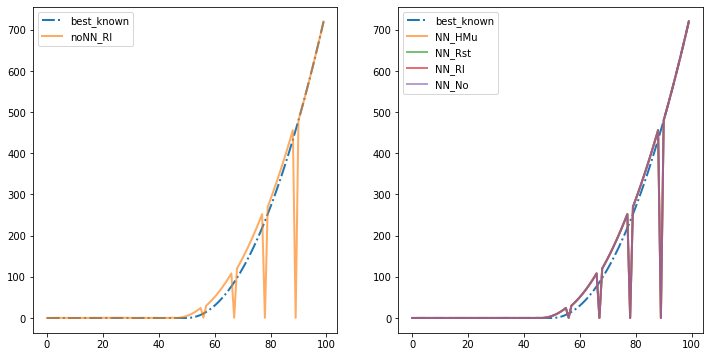

In [4]:
#one single plot
exp ='exp3'
func='sphere'
fig,ax = plt.subplots(1,2,figsize=(12,6))

plot_noNN(exp, func, freq, ax[0])
plot_NN(exp, func, freq, ax[1])

# fig.savefig(f'../../data/cluster_results/fitnesssep{exp}.eps', dpi=400, format='eps')

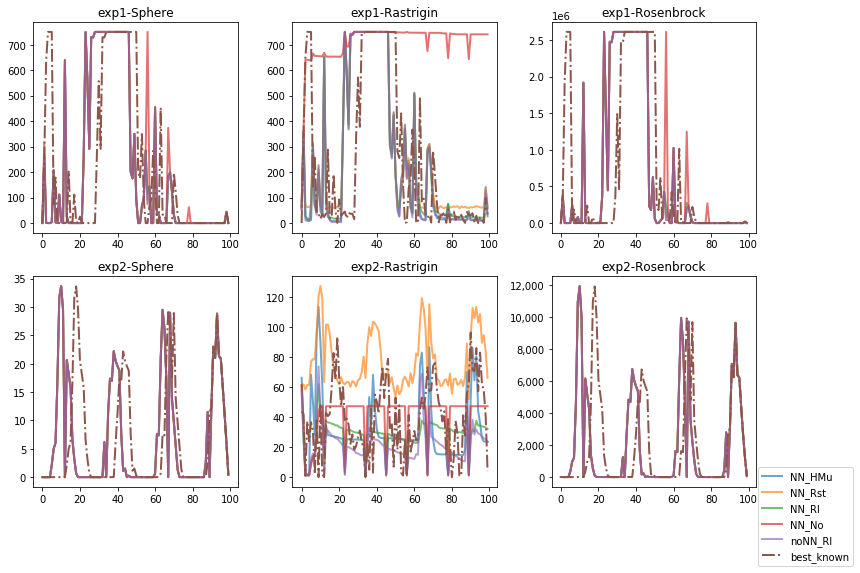

In [5]:
# one Plot
fig,axs = plt.subplots(2, 3, figsize=(12,8))#14,6 for only two plot

for ax_row,exp in zip(axs,exps):
    for ax,func in zip(ax_row,funcs):
        plot_one(exp, func, freq, ax)
        # plot best
        best_values = best_knowns.query(f'experiment == {exp!r} and function=={func!r}').fitness.values
        ax.plot(best_values, lw=2, ls='-.', label='best_known')
        ax.set_title(f'{exp}-{func.title()}')
        ax.ticklabel_format(style='sci', scilimits=(0,5), useOffset=False)
        if ax.get_ylim()[1] < 1e5:
            ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        
ax.legend(loc='lower right', bbox_to_anchor=(1.4, -0.4, 0.1, 0.1))# bbox ``(x, y, width, height)``
plt.tight_layout()
freq_lbl = f'{freq*10:02.0f}' if freq<1 else freq

# fig.savefig(f'../../data/cluster_results/fitnessall{freq_lbl}.eps', dpi=400, format='eps')

In [ ]:
# all Plots together
fig,axs = plt.subplots(4, 3, figsize=(12,8))#14,6 for only two plot

for ax_row,exp in zip(axs,exps):
    for ax,func in zip(ax_row,funcs):
        plot_one(exp, func, freq, ax)
        # plot best
        best_values = best_knowns.query(f'experiment == {exp!r} and function=={func!r}').fitness.values
        ax.plot(best_values, lw=2, ls='-.', label='best_known')
        ax.set_title(f'{exp}-{func.title()}')
        ax.ticklabel_format(style='sci', scilimits=(0,5), useOffset=False)
        if ax.get_ylim()[1] < 1e5:
            ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        
ax.legend(loc='lower right', bbox_to_anchor=(1.4, -0.4, 0.1, 0.1))# bbox ``(x, y, width, height)``
plt.tight_layout()
freq_lbl = f'{freq*10:02.0f}' if freq<1 else freq

# fig.savefig(f'../../data/cluster_results/fitnessall{freq_lbl}.eps', dpi=400, format='eps')